In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.stats import norm

In [2]:
with h5py.File('hw3_data2.mat', 'r') as f:
    print(f.keys())
    yn = f['Yn'].value.T
    xn = f['Xn'].value.T
    yn = yn.astype(float)
    xn = xn.astype(float)
print('Yn:', yn.shape)
print('Xn:', xn.shape)

<KeysViewHDF5 ['Xn', 'Yn']>
Yn: (1000, 1)
Xn: (1000, 100)


c:\users\ayhok\appdata\local\programs\python\python37\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


## Part A

In [3]:
def findRidgeSol(X,y,r_coeff=0):
    xTx = np.matmul(X.T, X)
    xTy = np.matmul(X.T, y)
    return np.matmul(np.linalg.inv(xTx+r_coeff*np.identity(xTx.shape[0])), xTy)

In [4]:
def cvSplit(X,y,turn):
    FOLD = 10
    num_sample = X.shape[0]
    num_fold = int(num_sample/FOLD)
    val_ind = turn*num_fold
    test_ind = (turn+1)*num_fold
    val_end = test_ind
    if(test_ind >= num_sample):
        test_ind = 0
    train_ind = test_ind + num_fold
    test_end = train_ind
    if(train_ind >= num_sample):
        train_ind = 0
    X_val_set = X[val_ind:val_end]
    y_val_set = y[val_ind:val_end]
    X_test_set = X[test_ind:test_end]
    y_test_set = y[test_ind:test_end]
    if(train_ind == 2*num_fold):
        X_train_set = X[train_ind:num_sample]
        y_train_set = y[train_ind:num_sample]
    elif(train_ind == 0):
        X_train_set = X[0:val_ind]
        y_train_set = y[0:val_ind]
    elif(train_ind == num_fold):
        X_train_set = X[train_ind:val_ind]
        y_train_set = y[train_ind:val_ind]
    else:
        X_train_set = np.vstack((X[0:val_ind], X[train_ind:num_sample]))
        y_train_set = np.vstack((y[0:val_ind], y[train_ind:num_sample]))
    return(X_train_set,y_train_set,X_val_set,y_val_set,X_test_set,y_test_set)    

In [5]:
def calc_r2(y_true, y_pred):
    pearson = np.corrcoef(y_true.T,y_pred.T)[0,1]
    return pearson**2

In [6]:
ridge_params = np.logspace(0, 12, num=500, base=10)

r_2_list_val = []
r_2_list_test = []
for coeff in ridge_params:
    sum_r_2_val = 0
    sum_r_2_test = 0
    for i in range(10):
        X_train, y_train, X_val, y_val, X_test, y_test = cvSplit(xn,yn,i)
        w_ridge = findRidgeSol(X_train, y_train, coeff)
        test_pred = np.matmul(X_test, w_ridge)
        val_pred = np.matmul(X_val,w_ridge)
        r_sq_val = calc_r2(y_val, val_pred)
        r_sq_test = calc_r2(y_test, test_pred)
        sum_r_2_val += r_sq_val
        sum_r_2_test += r_sq_test
        
    r_2_list_val.append(sum_r_2_val/10)
    r_2_list_test.append(sum_r_2_test/10)

Optimal Lambda Value: 395.5436244734702
Best Average R^2 Value for Validation 0.1525988778486
Best Average R^2 Value for Test 0.1604206104492847


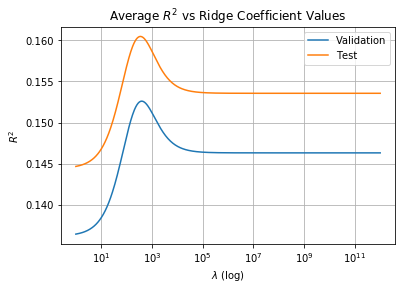

In [7]:
opt_lamda = ridge_params[np.argmax(r_2_list_val)]
print('Optimal Lambda Value:', opt_lamda)
print('Best Average R^2 Value for Validation', r_2_list_val[np.argmax(r_2_list_val)])
print('Best Average R^2 Value for Test', r_2_list_test[np.argmax(r_2_list_val)])

plt.xscale('log')
plt.xlabel('$\lambda$ (log)')
plt.ylabel('$R^2$')
plt.title('Average $R^2$ vs Ridge Coefficient Values')
plt.grid('on')
plt.plot(ridge_params,np.asarray(r_2_list_val))
plt.plot(ridge_params,np.asarray(r_2_list_test))
plt.legend(['Validation', 'Test'])

plt.show()

## Part B

In [8]:
def gen_bootstrap(X,y):
    num_sample = X.shape[0]
    seq = [np.random.randint(0,num_sample) for i in range(num_sample)]
    X_boot = X[seq]
    y_boot = y[seq]
    return (X_boot, y_boot)

In [9]:
BOOTSTRAP_ITER = 500
w_boots = []
for i in range(BOOTSTRAP_ITER):
    x_boot, y_boot = gen_bootstrap(xn,yn)
    w_boot = findRidgeSol(x_boot,y_boot)
    w_boots.append(w_boot)
w_boots = np.asarray(w_boots)
print(w_boots.shape)

w_means = np.mean(w_boots, axis=0)
w_stds = np.std(w_boots, axis=0)

print(w_means.shape, w_stds.shape)

(500, 100, 1)
(100, 1) (100, 1)


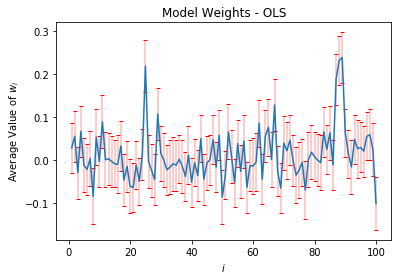

In [10]:
x_ = np.arange(100)+1
plt.errorbar(x_, w_means[:,0], yerr=2*w_stds[:,0], ecolor='r', elinewidth=0.4, capsize=2)
plt.title('Model Weights - OLS')
plt.xlabel('$i$')
plt.ylabel('Average Value of $w_i$')
plt.show()


In [11]:
z = w_means / w_stds
p = 2*(1-norm.cdf(np.abs(z)))
significant_OLS = np.argwhere(p < 0.05)
significant_OLS = significant_OLS[significant_OLS != 0]
print('Indices of i different than 0:\n', significant_OLS)


Indices of i different than 0:
 [ 3  7 10 20 24 28 48 49 51 57 61 64 66 68 76 82 84 86 87 88 89 96 97 99]


## Part C

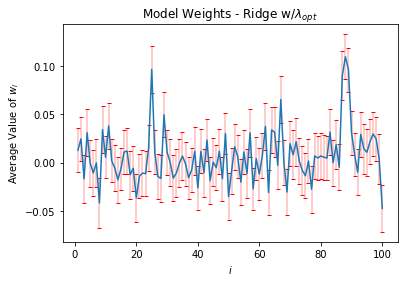

In [12]:
BOOTSTRAP_ITER = 500
w_boots = []
for i in range(BOOTSTRAP_ITER):
    x_boot, y_boot = gen_bootstrap(xn,yn)
    w_boot = findRidgeSol(x_boot,y_boot,opt_lamda)
    w_boots.append(w_boot)
w_boots = np.asarray(w_boots)

w_means = np.mean(w_boots, axis=0)
w_stds = np.std(w_boots, axis=0)

x_ = np.arange(100)+1
plt.errorbar(x_, w_means[:,0], yerr=2*w_stds[:,0], ecolor='r', elinewidth=0.4, capsize=2)
plt.title('Model Weights - Ridge w/$\lambda_{opt}$')
plt.xlabel('$i$')
plt.ylabel('Average Value of $w_i$')
plt.show()


In [13]:
z = w_means / w_stds
p = 2*(1-norm.cdf(np.abs(z)))
significant_OLS = np.argwhere(p < 0.05).flatten()
significant_OLS = significant_OLS[significant_OLS != 0]
print('Indices of i that are different than 0:\n', significant_OLS)


Indices of i that are different than 0:
 [ 1  3  7  8 10 19 24 28 39 42 48 49 56 57 61 62 63 64 66 68 76 82 86 87
 88 89 92 96 97 99]
